In [18]:
%load_ext autoreload
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
from utils import *
import scipy.misc
import glob

def times100(x):
    return 100 * np.max(x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
log_dir = '../log'
runs = glob.glob("{}/*/".format(log_dir))

subset = ['baseline',
          'two-paths-cutout-conv-minus-0.1',
          'two-paths-cutout-conv-zero']
excludes = ['preact_tester']
results = {}
epochs_to_show = 200
for run in runs:
   
    if (len(subset) == 0 or (len(subset) and run.split('/')[-2] in subset)) and run.split('/')[-2] not in excludes:
        results[run] = read_results('{}/summary_logs/result_summary_statistics.csv'.format(run))
        print('Loading {}, {} epochs'.format(run.split('/')[-2], len(results[run]['epoch'])))
        if len(results[run]['epoch']) < epochs_to_show:
            epochs_to_show = len(results[run]['epoch'])
            
epochs_to_show = 200

Loading baseline, 233 epochs
Loading two-paths-cutout-conv-minus-0.1, 200 epochs
Loading two-paths-cutout-conv-zero, 200 epochs


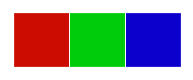

In [20]:
colours = sns.hls_palette(len(results), l=0.4, s=1)#sns.color_palette('bright', len(results))
sns.palplot(colours)

xlims = [0,200]

stats_to_plot = {
    '{}_loss':('Loss', np.min, [-0.001, 2]),
    '{}_loss_sim':('Loss Sim', np.min, [-0.01, 0]),
    '{}_loss_reg':('Loss Reg', np.min, [-0.001, 0.1]),
    '{}_acc':('Accuracy', times100, [0.4, 1.01]),
    
}

linewidth = 2.5
w = 2
h = np.ceil(len(stats_to_plot)/w)

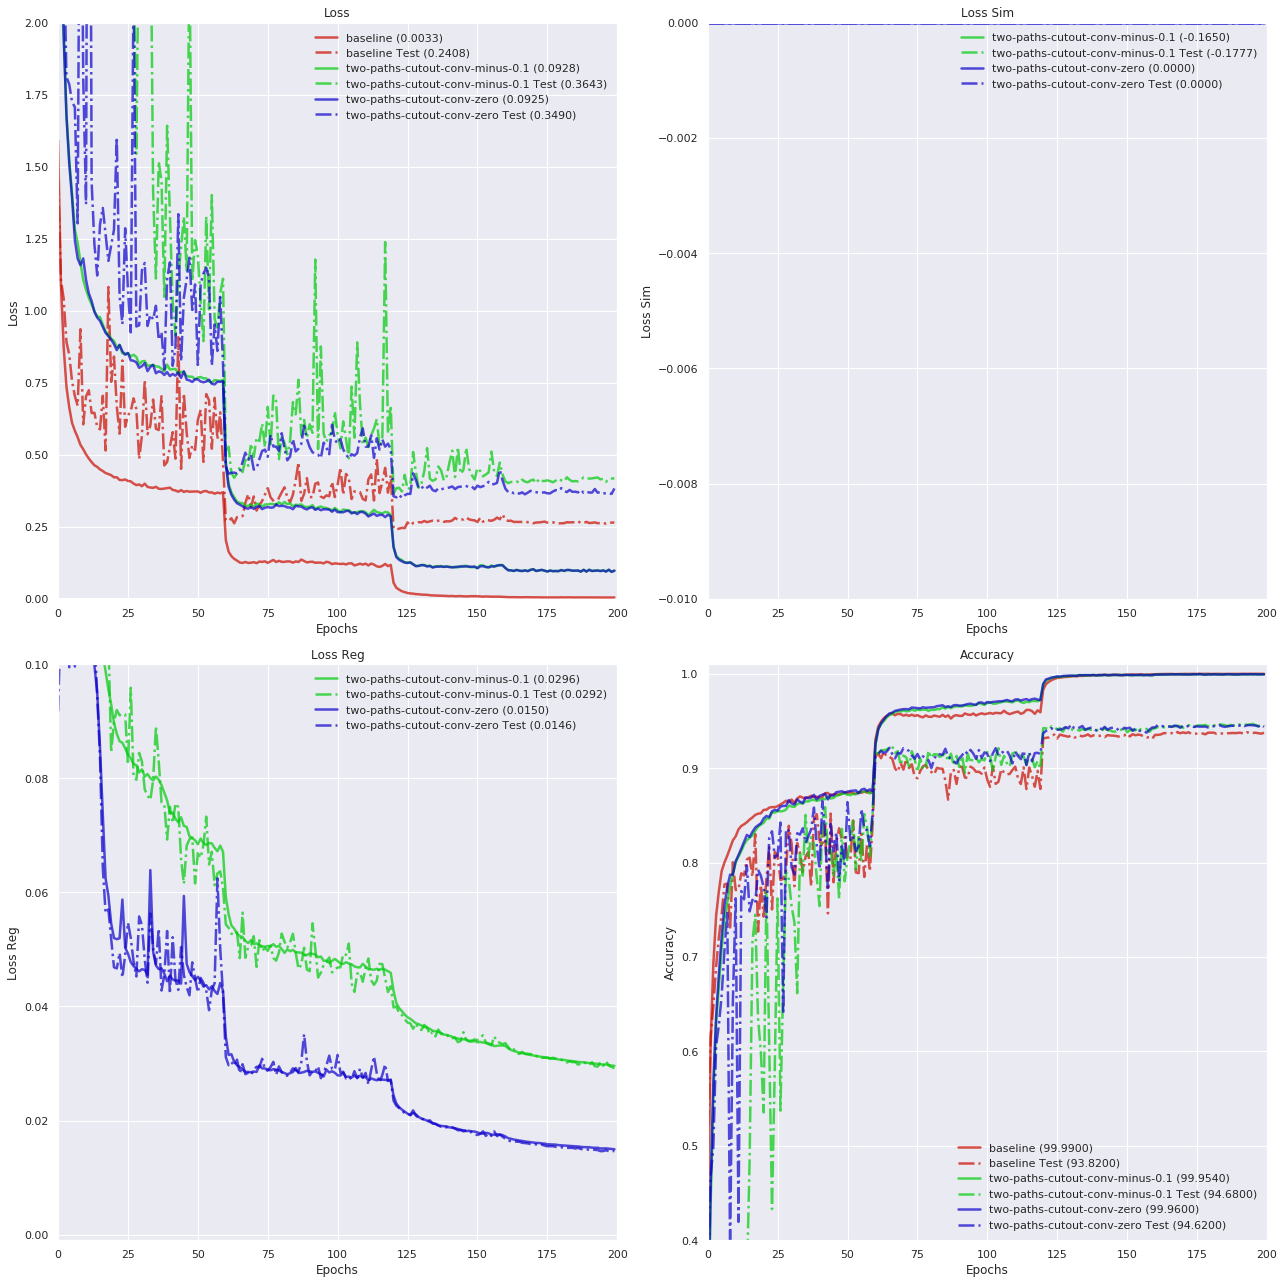

In [21]:
fig = plt.figure(figsize=(18, 9 * h))
ploti = 1

marker=''
for stat, (title, label_function, ylims) in stats_to_plot.items():
    ax = fig.add_subplot(h, w, ploti)
    allresults = np.array([])
    for i, (run, thisresult) in enumerate(results.items()):
        if stat.format('train') in thisresult.keys():
            epochs = thisresult['epoch']
            if len(epochs) > epochs_to_show:
                epochs = epochs[:epochs_to_show]
            train_stat = thisresult[stat.format('train')]
            if len(train_stat) > epochs_to_show:
                train_stat = train_stat[:epochs_to_show]
            test_stat = thisresult[stat.format('test')]
            if len(test_stat) > epochs_to_show:
                test_stat = test_stat[:epochs_to_show]
                
            if 'acc' in stat:
                train_stat = np.array(train_stat)
                train_stat[np.array(train_stat) > 1.0] /= 2

            allresults = np.concatenate((allresults, 
                                         train_stat[(5 if len(train_stat) > 5 else 0):], 
                                         test_stat[(5 if len(test_stat) > 5 else 0):]))
            label = run.split('/')[-2]
            ax.plot(epochs, train_stat, color=colours[i], marker=marker,
                    label='{} ({:0.4f})'.format(label, label_function(train_stat)), alpha=0.7, 
                    linewidth=linewidth)
            ax.plot(epochs, test_stat, color=colours[i], linestyle='-.', marker=marker,
                    label='{} Test ({:0.4f})'.format(label, label_function(test_stat)), alpha=0.7, 
                    linewidth=linewidth)

    
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.set_title(title)

    ax.legend(frameon=False, ncol=1)
    ploti+= 1
fig.tight_layout()
fig.savefig('stats.pdf')